# Загрузка данных

Мы будем использовать [выборку Bank Marketing](https://quiltdata.com/package/uciml/bank).
Объектом в выборке является клиент банка, которому совершался звонок с предложением депозитного продукта.
Целевая переменная – согласие на продукт.

Для загрузки данных воспользуемся библиотекой [quilt](https://quiltdata.com).

```bash
pip install quilt
```

In [1]:
# Для первой загрузки
# import quilt
# quilt.install('uciml/bank')
# quilt.rm('packet')
from quilt.data.uciml import bank

bank_full = bank.tables.bank_full()
bank_full.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [2]:
bank_full.to_csv('inf.csv')

# Подготовка данных

In [3]:
import numpy as np
import pandas as pd

features = ['age', 'job', 'marital', 'education', 'default', 'balance', 
            'housing', 'loan', 'contact', 'campaign',
            'pdays', 'previous', 'poutcome']  # 'duration'

cat_features = bank_full[features].select_dtypes(object).columns
num_features = bank_full[features].select_dtypes(np.number).columns

In [4]:
cat_features

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'poutcome'],
      dtype='object')

In [5]:
bank_full[cat_features].apply(pd.Series.nunique)

job          12
marital       3
education     4
default       2
housing       2
loan          2
contact       3
poutcome      4
dtype: int64

**Задание.** Произвести one hot кодировку категориальных полей.

Hint: [`pd.concat`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.concat.html), [`pd.get_dummies`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html).

In [6]:
# парсим признаки
X = pd.concat([bank_full[num_features], pd.get_dummies(bank_full[cat_features])], axis = 1)
X.shape

(45211, 37)

In [7]:
y = bank_full['y'].replace({'yes': 1, 'no': 0})

In [8]:
X.columns

Index(['age', 'balance', 'campaign', 'pdays', 'previous', 'job_admin.',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'education_primary', 'education_secondary', 'education_tertiary',
       'education_unknown', 'default_no', 'default_yes', 'housing_no',
       'housing_yes', 'loan_no', 'loan_yes', 'contact_cellular',
       'contact_telephone', 'contact_unknown', 'poutcome_failure',
       'poutcome_other', 'poutcome_success', 'poutcome_unknown'],
      dtype='object')

Разделим выборку по времени

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

# Извлечение зависимости

In [10]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

In [11]:
cv = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

clf = GradientBoostingClassifier(learning_rate=0.1, n_estimators=10)

cv_score = cross_val_score(clf, X_train, y_train, cv=cv, scoring='roc_auc')
cv_score

array([ 0.74068125,  0.76485647,  0.72109754])

In [12]:
cv

StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

---

In [13]:
from sklearn.model_selection import GridSearchCV

In [14]:
booster_grid = {'learning_rate': [0.1, 0.05, 0.01], 'max_depth': [2, 3]}

booster = GradientBoostingClassifier(n_estimators=100)

gs_booster = GridSearchCV(booster, booster_grid, scoring='roc_auc',
                          cv=cv, verbose=1, n_jobs=-1, return_train_score=True)

In [15]:
gs_booster.fit(X_train, y_train);
gs_booster.best_params_

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   14.0s finished


{'learning_rate': 0.1, 'max_depth': 3}

In [16]:
pd.DataFrame(gs_booster.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_learning_rate,param_max_depth,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,2.274566,0.035454,0.764558,0.775425,0.1,2,"{'learning_rate': 0.1, 'max_depth': 2}",2,0.759134,0.779330,0.781189,0.767044,0.753351,0.779902,0.038476,0.002185,0.011994,0.005931
1,3.752168,0.037174,0.765775,0.788252,0.1,3,"{'learning_rate': 0.1, 'max_depth': 3}",1,0.758712,0.791836,0.783356,0.780445,0.755257,0.792475,0.071225,0.004117,0.012511,0.005527
2,2.272488,0.031222,0.761086,0.768020,0.05,2,"{'learning_rate': 0.05, 'max_depth': 2}",4,0.757380,0.772187,0.777255,0.760229,0.748624,0.771645,0.021640,0.000390,0.011978,0.005514
3,4.029166,0.035828,0.763859,0.777082,0.05,3,"{'learning_rate': 0.05, 'max_depth': 3}",3,0.757399,0.780938,0.780516,0.769170,0.753660,0.781138,0.048004,0.000880,0.011877,0.005595
4,1.963795,0.029821,0.722536,0.723910,0.01,2,"{'learning_rate': 0.01, 'max_depth': 2}",6,0.728254,0.737052,0.739292,0.711105,0.700059,0.723572,0.035764,0.000816,0.016519,0.010596
5,2.771994,0.018671,0.745545,0.749447,0.01,3,"{'learning_rate': 0.01, 'max_depth': 3}",5,0.741309,0.753156,0.766146,0.740151,0.729178,0.755033,0.226698,0.001199,0.015386,0.006618


---

**Задание** Подберите параметр количества соседей для KNeighborsClassifier в диапозоне [1, 5, 10], делая при этом нормировку StandardScaler

Hint: для [`make_pipeline`](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html)

In [17]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


# <вставить код>
knn_grid = {'kneighborsclassifier__n_neighbors': [1, 5, 10]}

knn = make_pipeline(StandardScaler(), KNeighborsClassifier())
knn

Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('kneighborsclassifier', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))])

In [18]:
gs_knn = GridSearchCV(knn, knn_grid, scoring='roc_auc', cv=cv, verbose=1, n_jobs=-1, return_train_score=True)

In [19]:
gs_knn.fit(X_train, y_train)
gs_knn.best_params_

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  2.0min finished


{'kneighborsclassifier__n_neighbors': 10}

In [20]:
pd.DataFrame(gs_knn.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_kneighborsclassifier__n_neighbors,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,1.718514,11.406904,0.589660,0.999294,1,{'kneighborsclassifier__n_neighbors': 1},3,0.585324,0.998904,0.598625,0.999433,0.585031,0.999545,0.735873,0.173679,0.006340,0.000279
1,1.235869,21.282359,0.666097,0.908049,5,{'kneighborsclassifier__n_neighbors': 5},2,0.661010,0.910443,0.685381,0.903159,0.651900,0.910545,0.893753,0.610231,0.014134,0.003458
2,0.828012,22.034002,0.686695,0.861610,10,{'kneighborsclassifier__n_neighbors': 10},1,0.686081,0.864004,0.699011,0.856100,0.674992,0.864726,0.357278,3.137696,0.009815,0.003907


---

**Задание** Перед запуском Knn произведите отбор самых важных признаков, используя [`SelectFromModel`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html), перебирая значения `threshold` в диапозоне ['0.1*mean', '0.5*mean', 'mean'], а в качестве модели взять [`DecisionTreeClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html).

In [21]:
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier

In [22]:
tree = DecisionTreeClassifier(max_depth = 10).fit(X_train, y_train)

In [23]:
selector = SelectFromModel(tree)

In [24]:
# knn_sel = make_pipeline()
# <вставить код>

knn_sel_grid = {'selectfrommodel__threshold' : ['0.1*mean', '0.5*mean', 'mean']}
knn_sel = make_pipeline(StandardScaler(), SelectFromModel(tree), KNeighborsClassifier(n_neighbors = 5))

gs_knn_sel = GridSearchCV(knn_sel, knn_sel_grid, scoring='roc_auc', cv=cv, verbose=1, n_jobs=-1, return_train_score=True)

In [25]:
gs_knn_sel.fit(X_train, y_train)
gs_knn_sel.best_params_

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   25.5s finished


{'selectfrommodel__threshold': '0.1*mean'}

In [26]:
knn_sel.set_params(selectfrommodel__threshold= '0.5*mean')

Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('selectfrommodel', SelectFromModel(estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_s...owski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))])

In [27]:
pd.DataFrame(gs_knn_sel.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_selectfrommodel__threshold,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,1.484937,10.325887,0.672665,0.908735,0.1*mean,{'selectfrommodel__threshold': '0.1*mean'},1,0.657267,0.912147,0.696855,0.903060,0.663875,0.910997,0.552916,0.428313,0.017316,0.004040
1,0.757974,0.715221,0.667783,0.903525,0.5*mean,{'selectfrommodel__threshold': '0.5*mean'},2,0.661734,0.903098,0.681955,0.899143,0.659659,0.908334,0.459954,0.061190,0.010057,0.003765
2,0.259822,0.432406,0.667407,0.901318,mean,{'selectfrommodel__threshold': 'mean'},3,0.658895,0.902223,0.684435,0.899739,0.658891,0.901994,0.041331,0.086044,0.012041,0.001121


# Stacking

In [28]:
booster = gs_booster.best_estimator_
knn = gs_knn.best_estimator_
knn_sel = gs_knn_sel.best_estimator_

**Задание** Написать функцию, которая возвращает прогноз по схеме кросс-валидации на обучающей выборке и на тесте.

Hint: не забудьте использовать метод `'predict_proba'` для [`cross_val_predict`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html)

In [29]:
from sklearn.model_selection import cross_val_predict


def meta_feature(clf, X_train, y_train, X_test, cv, verbose = 1):
    cv_pred_train = cross_val_predict(clf, X_train, y = y_train, cv = cv,
                                      method = 'predict_proba', n_jobs= -1, verbose = verbose)[:, 1]
    clf.fit(X_train, y_train)
    pred_test = clf.predict_proba(X_test)[:, 1]
    return cv_pred_train, pred_test

def meta_feature_predict(clf, X_train, y_train, X_test, cv, verbose = 1):
    cv_pred_train = cross_val_predict(clf, X_train, y = y_train, cv = cv,
                                      method = 'predict', n_jobs= -1, verbose = verbose)[:, 1]
    clf.fit(X_train, y_train)
    pred_test = clf.predict(X_test)[:, 1]
    return cv_pred_train, pred_test

In [30]:
meta_train = pd.DataFrame()
meta_test = pd.DataFrame()

meta_train['booster'], meta_test['booster'] = meta_feature(booster, X_train, y_train, X_test, cv)
meta_train['knn'    ], meta_test['knn'    ] = meta_feature(knn,     X_train, y_train, X_test, cv)
meta_train['knn_sel'], meta_test['knn_sel'] = meta_feature(knn_sel, X_train, y_train, X_test, cv)

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.2s finished
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   24.1s finished
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.9s finished


In [31]:
meta_train.head()

,booster,knn,knn_sel
0,0.086995,0.1,0.2
1,0.361659,0.0,0.2
2,0.094236,0.2,0.0
3,0.166644,0.0,0.0
4,0.116443,0.2,0.2


In [32]:
meta_test.head()

,booster,knn,knn_sel
0,0.550634,0.7,0.6
1,0.046196,0.0,0.0
2,0.082606,0.0,0.0
3,0.652086,0.9,1.0
4,0.397968,0.6,0.2


In [33]:
from sklearn.metrics import roc_auc_score
meta_test.apply(lambda x: roc_auc_score(y_test, x))

booster    0.755696
knn        0.688348
knn_sel    0.667548
dtype: float64

In [34]:
meta_clf = GradientBoostingClassifier()
meta_clf.fit(meta_train, y_train)

roc_auc_score(y_test, meta_clf.predict_proba(meta_test)[:, 1])

0.75394824713100272

---

## Домашнее Задание. Information value
Реализовать функцию подсчета [information value](http://ucanalytics.com/blogs/information-value-and-weight-of-evidencebanking-case). 

* в функции признак должен разбиваться на `num_buck` бакетов.
* для каждого бакета подсчитайте величину
$$
    \left(    \frac{tr}{all\_tr} -       \frac{1 - tr}{1 - all\_tr} \right) \cdot
    \left(log(\frac{tr}{all\_tr}) -  log(\frac{1 - tr}{1 - all\_tr})\right) \cdot
    \frac{cnt}{all\_cnt},
$$
    * $tr$ - доля целевой переменной в бакете (target rate)
    * $all\_tr$ - доля целевой переменной во всей выборке
    * $cnt$ - количество объектов в бакете
    * $all_cnt$ - количество обектов во всей выборке
    
* Если в бакете объекты только одного класса, то будут проблемы со взятием логарифма. Для этого значения $tr$ надо обрезать снизу – 0.001, а сверху 0.999 (hint: [`np.clip`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.clip.html))

In [35]:
def information_value(feature, target, num_buck=10):
    data = pd.DataFrame({'feature': feature, 'tr': target})
    all_tr = np.mean(target)
    all_cnt = len(target)
    bucket = np.floor((data['feature'].rank(pct=True) * num_buck))
    data = data.assign(bucket = pd.Series(bucket).values, cnt = 1)
    iv = data.groupby('bucket') \
             .agg({'tr': 'mean', 'cnt': 'sum'}) \
             .assign(tr = lambda x: np.clip(x['tr'], 0.001, 0.999)) \
             .eval('((tr / {all_tr}) - ((1 - tr) / (1 - {all_tr}))) \
               * (log(tr / {all_tr}) - log((1 - tr) / (1 - {all_tr}))) \
               * (cnt / {all_cnt})' 
             .format(all_tr=all_tr, all_cnt=all_cnt), inplace = False) \
             .sum()
    return iv

Check our new function:

In [36]:
feature = X_train['age']
target = y_train

In [37]:
information_value(feature, target)

0.10408301030599967

## Домашнее Задание. Важность признаков

Для некоторых задач важно уметь отобрать топ самых информативных признаков, выкинув неинформативный хвост.

Произвести сравнение различных способов подсчета важности признаков.

Способы подсчета важности:
* feature importance градиентного бустинга;
* information value;
* feature importance от random forest.

Способ сравнения:
* Фиксируйте одну модель по выбору.
* В качестве признаков нужно использовать топ-n от итоговых признаков по критерию важности.
* Построить зависимость качества на тесте от количества признаков n для каждого способа.

**Замечание**

Учесть, что первоначальному одному признаку соответствует несколько признаков после one hot кодирования, а в задании под принаком подразумеваются исходные (age, job, ...). При подсчете feature importance от категориальных полей нужно складывать feature importance всех получиных после one hot кодировки бинарных признаков.


Для каких способов совпадают наборы признаков для n = 1, 2, 3?  
Какой способ дает лучшее качество на тесте при использовании 5 признаков?

В качестве модели выбран booster с семинара

In [38]:
info = {
    'age': ['age'], 
    'job' : ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid','job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown'],
    'marital' : ['marital_married', 'marital_single', 'marital_divorced'],
    'education' : ['education_tertiary', 'education_primary', 'education_secondary', 'education_unknown'], 
    'balance' : ['balance'],
    'housing' : ['housing_no', 'housing_yes'],
    'loan' : ['loan_yes', 'loan_no'], 
    'contact' : ['contact_unknown', 'contact_cellular', 'contact_telephone'],
    'default' : ['default_no', 'default_yes'],
    'campaign' : ['campaign'],
    'pdays' : ['pdays'],
    'previous' : ['previous'],
    'poutcome' : ['poutcome_success', 'poutcome_failure', 'poutcome_unknown', 'poutcome_other']
 }

def importance_convertation(rawImportance):
    res = pd.Series(np.zeros(len(features)), index = features)
    for feature in features:
        for rawfeature in info[feature]:
            res[feature] += rawImportance[rawfeature]
    return res.sort_values(ascending=False)

In [39]:
def list_important(ConvImportance, n):
    res = []
    for i in range(min(n, len(ConvImportance))):
        for rawfeature in info[ConvImportance.index[i]]:
            res.append(rawfeature)
    return res

In [40]:
def roc_auc_score_n_features(ConvImp, n, test_model):
    top_features = list_important(ConvImp, n)
    test_model.fit(X_train[top_features], y_train)
    return roc_auc_score(y_test, test_model.predict_proba(X_test[top_features])[:, 1])

In [41]:
import matplotlib.pyplot as plt
def draw_res(ConvImp, name = None):
    experiments = []
    for n in range(1, len(features) + 1):
        experiments.append([n, roc_auc_score_n_features(ConvImp, n, gs_booster.best_estimator_)])
    plt.figure(figsize=(10, 5))
    plt.grid(True)
    if (name):
        plt.title(name)
    experiments = np.array(experiments)
    plt.plot(experiments[:, 0], experiments[:, 1])
    plt.xlabel('number of features')
    plt.ylabel('roc_auc_score')
    plt.show()

Booster importance:

In [42]:
predictor = booster.fit(X_train, y_train)
boosterImportance = pd.Series(predictor.feature_importances_, index=X_train.columns).sort_values(ascending=False)

In [43]:
boosterConvImp = importance_convertation(boosterImportance)
print(boosterConvImp)

pdays        0.209499
balance      0.154190
age          0.138839
poutcome     0.125293
housing      0.067094
previous     0.061988
job          0.058799
campaign     0.055749
contact      0.048687
loan         0.028469
marital      0.026420
education    0.024974
default      0.000000
dtype: float64


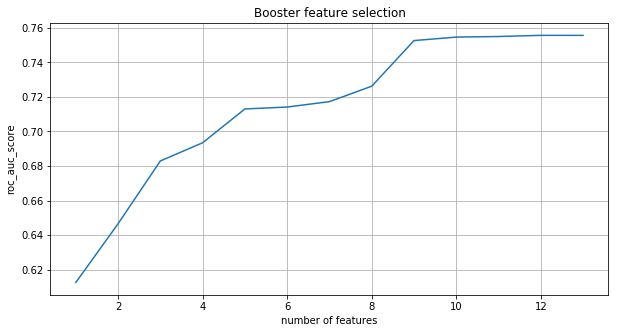

In [44]:
draw_res(boosterConvImp, "Booster feature selection")

In [45]:
roc_auc_score_n_features(boosterConvImp, 5, gs_booster.best_estimator_)

0.71303878624254879

Information value importance:

In [46]:
IVfeatures = np.array([information_value(X_train[feature], y_train) for feature in X_train.columns])
IVImportance = pd.Series(IVfeatures, index=X_train.columns).sort_values(ascending=False)

In [47]:
IVConvImp = importance_convertation(IVImportance)
print(IVConvImp)

poutcome     0.761036
contact      0.500098
housing      0.389798
pdays        0.297551
previous     0.238408
job          0.177164
balance      0.132096
loan         0.112579
age          0.104083
marital      0.091875
campaign     0.078190
education    0.070932
default      0.015676
dtype: float64


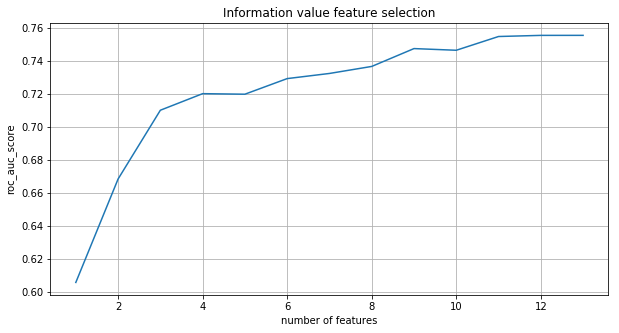

In [48]:
draw_res(IVConvImp, "Information value feature selection")

In [49]:
roc_auc_score_n_features(IVConvImp, 5, gs_booster.best_estimator_)

0.71991830824524872

ExtraTrees(= Random forest) Importance:

In [50]:
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, AdaBoostClassifier
forest = RandomForestClassifier(n_estimators=50, random_state=0).fit(X_train, y_train)
forestImportance = pd.Series(forest.feature_importances_, index=X_train.columns).sort_values(ascending=False)

In [51]:
forestConvImp = importance_convertation(forestImportance)
print(forestConvImp)

balance      0.303628
age          0.216755
job          0.089299
poutcome     0.082986
campaign     0.081699
pdays        0.061585
education    0.039177
previous     0.028135
marital      0.028050
housing      0.025773
contact      0.024583
loan         0.015100
default      0.003231
dtype: float64


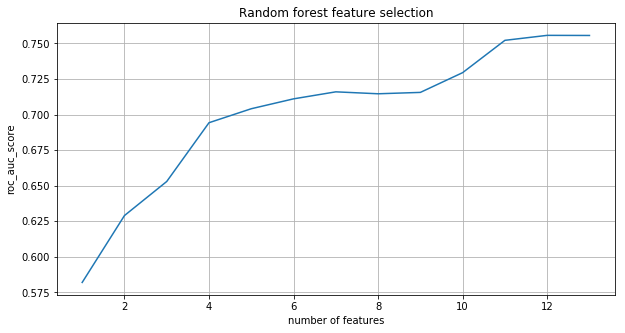

In [52]:
draw_res(forestConvImp, "Random forest feature selection")

In [53]:
roc_auc_score_n_features(forestConvImp, 5, gs_booster.best_estimator_)

0.7042716046179357

* Смысла писать при каких n совпали наборы я не вижу, поскольку все это зависит от текущего сплита на трейн и тест, к тому же топ IV кардинально отличается от топа boostera и деревьев. В топ 3 как у бустера, так и у деревьев входит balance и age.
* Наилучшее качество при пяти параметрах стабильно дает information value.

## Домашнее Задание. Stacking.

Попробовать стэкинг различных наборов моделей:
* Одну и туже модель с разными гиперпараметрами параметрами (например, бустинг с разным количеством деревьев);
* Разнообразные модели.

Попробовать различные мета классификаторы и простое усреднение.

Получилось ли за счет стэкинга улучшить качество?
Какое метод дает большее качество на тесте?

Начнем того что очень сложно понять что такое stacking просто по семинару, поэтому воспользовался несколькими ссылками, которые на мой взгляд многое хорошо объясняют, пожалуй лучшая вот:

https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python?scriptVersionId=936973

In [54]:
from tqdm import tqdm
def mean_meta(clf, X_train, y_train, X_test, n_splits = 3, n = 50, start_log = 1.2, end_log = 1.8):
    meta_train = 0
    meta_test = 0
    for n_estimators in tqdm(np.array(np.logspace(start_log, end_log, num = n), dtype = int)):
        cv = StratifiedKFold(n_splits=n_splits, random_state=42, shuffle=True)
        predictor = 0
        if (clf == 'booster'):
            predictor = GradientBoostingClassifier(n_estimators = n_estimators)
        elif (clf == 'rforest'):
            predictor = RandomForestClassifier(n_estimators = n_estimators)
        elif (clf == 'etrees'):
            predictor = ExtraTreesClassifier(n_estimators = n_estimators)
        elif (clf == 'knn'):
            predictor = KNeighborsClassifier(n_neighbors = n_estimators)
        elif (clf == 'AdaBoost'):
            predictor = AdaBoostClassifier(n_estimators = n_estimators)
        if (predictor != 0):
            if (type(meta_train) == int):
                meta_train, meta_test = meta_feature(predictor, X_train, y_train, X_test, cv, 0)
            else:
                train, test = meta_feature(predictor, X_train, y_train, X_test, cv, 0)
                meta_train += train
                meta_test += test
    return meta_train / n, meta_test / n

In [55]:
from tqdm import tqdm
def stack_meta(clf, X_train, y_train, X_test, n_splits = 3, n = 50, start_log = 1.2, end_log = 1.8):
    meta_train = 0
    meta_test = 0
    for n_estimators in tqdm(np.array(np.logspace(start_log, end_log, num = n), dtype = int)):
        cv = StratifiedKFold(n_splits = n_splits, random_state=42, shuffle=True)
        predictor = 0
        if (clf == 'booster'):
            predictor = GradientBoostingClassifier(n_estimators = n_estimators)
        elif (clf == 'rforest'):
            predictor = RandomForestClassifier(n_estimators = n_estimators)
        elif (clf == 'etrees'):
            predictor = ExtraTreesClassifier(n_estimators = n_estimators)
        elif (clf == 'knn'):
            predictor = KNeighborsClassifier(n_neighbors = n_estimators)
        elif (clf == 'AdaBoost'):
            predictor = AdaBoostClassifier(n_estimators = n_estimators)
        if (predictor != 0 ):
            if (type(meta_train) == int):
                meta_train, meta_test = meta_feature(predictor, X_train, y_train, X_test, cv, 0)
            else:
                train, test = meta_feature(predictor, X_train, y_train, X_test, cv, 0)
                meta_train = np.vstack((train, meta_train))
                meta_test = np.vstack((test, meta_test))
    return meta_train, meta_test

Попробуем использовать среднее от разных алгоритмов и настекать их:

In [56]:
meta_train = []
meta_test = []

In [57]:
splitter = [1.3, 1.6, 1.9, 2.1, 2.23]
for i in range(len(splitter) - 1):
    train, test = mean_meta('booster', X_train, y_train, X_test, n = 10, start_log = splitter[i], end_log = splitter[i + 1])
    meta_train.append(train)
    meta_test.append(test)

100%|██████████| 10/10 [01:30<00:00,  9.04s/it]


In [58]:
splitter = [1.35, 1.7, 1.85, 1.92]
for i in range(len(splitter) - 1):
    train, test = mean_meta('rforest', X_train, y_train, X_test, n = 10, start_log = splitter[i], end_log = splitter[i + 1])
    meta_train.append(train)
    meta_test.append(test)

100%|██████████| 10/10 [00:53<00:00,  5.34s/it]


In [59]:
splitter = [1.35, 1.7, 1.85, 1.92]
for i in range(len(splitter) - 1):
    train, test = mean_meta('etrees', X_train, y_train, X_test, n = 10, start_log = splitter[i], end_log = splitter[i + 1])
    meta_train.append(train)
    meta_test.append(test)

100%|██████████| 10/10 [00:57<00:00,  5.80s/it]


In [60]:
splitter = [0.02, 0.5, 0.9]
for i in range(len(splitter) - 1):
    train, test = mean_meta('knn', X_train, y_train, X_test, n = 10, start_log = splitter[i], end_log = splitter[i + 1])
    meta_train.append(train)
    meta_test.append(test)

100%|██████████| 10/10 [00:16<00:00,  1.64s/it]


In [61]:
splitter = [1.35, 1.7, 1.85, 1.92]
for i in range(len(splitter) - 1):
    train, test = mean_meta('AdaBoost', X_train, y_train, X_test, n = 10, start_log = splitter[i], end_log = splitter[i + 1])
    meta_train.append(train)
    meta_test.append(test)

100%|██████████| 10/10 [00:30<00:00,  3.07s/it]


In [62]:
meta_train = np.array(meta_train)
meta_test = np.array(meta_test)

Будем использовать мета фичи двумя популярными способами: 
* Бустером (всегда подойдет)
* Линейной моделью (логично, чтоб она взяла с какими-то хорошими весами хорошие модели, а плохие наоборот занулила)

In [63]:
meta_clf = GradientBoostingClassifier()
meta_clf.fit(meta_train.T, y_train)

roc_auc_score(y_test, meta_clf.predict_proba(meta_test.T)[:, 1])

0.75239770857864896

In [64]:
from sklearn.linear_model import SGDRegressor, Ridge
meta_clf = SGDRegressor()
meta_clf.fit(meta_train.T, y_train)
roc_auc_score(y_test, meta_clf.predict(meta_test.T))

0.75446350907944726

Попробуем не считать среднее, а просто стекать:

In [65]:
res = stack_meta('booster', X_train, y_train, X_test, n = 20, start_log = 2, end_log = 2.2)
meta_train = res[0]
meta_test = res[1]
res = stack_meta('rforest', X_train, y_train, X_test, n = 10, start_log = 1.7, end_log = 1.9)
meta_train = np.vstack((meta_train, res[0]))
meta_test = np.vstack((meta_test, res[1]))
res = stack_meta('etrees', X_train, y_train, X_test, n = 10, start_log = 1.7, end_log = 1.9)
meta_train = np.vstack((meta_train, res[0]))
meta_test = np.vstack((meta_test, res[1]))
res = stack_meta('knn', X_train, y_train, X_test, n = 10, start_log = 0.1, end_log = 0.9)
meta_train = np.vstack((meta_train, res[0]))
meta_test = np.vstack((meta_test, res[1]))
res = stack_meta('AdaBoost', X_train, y_train, X_test, n = 10, start_log = 1.7, end_log = 1.9)
meta_train = np.vstack((meta_train, res[0]))
meta_test = np.vstack((meta_test, res[1]))

100%|██████████| 10/10 [00:25<00:00,  2.59s/it]


In [66]:
meta_clf = GradientBoostingClassifier()
meta_clf.fit(meta_train.T, y_train)

roc_auc_score(y_test, meta_clf.predict_proba(meta_test.T)[:, 1])

0.75281603243076001

In [67]:
from sklearn.linear_model import SGDRegressor
meta_clf = SGDRegressor()
meta_clf.fit(meta_train.T, y_train)
roc_auc_score(y_test, meta_clf.predict(meta_test.T))

0.75609477942536851

Результат достигнут! Мы лучше, чем модель с семинара.

Выше мы попробовали натренить и настекать много так себе моделей. И посмотреть вдруг они все вместе дадут хороший результат.
Попробуем наоборот несколько хорошо обученных (как это делали товарищи из туториала с титаником):

In [85]:
# Random forest
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     #'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}
Rf = RandomForestClassifier(**rf_params)

# Extra Trees
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}
Et = ExtraTreesClassifier(**et_params)

# AdaBoost
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

ada = AdaBoostClassifier(**ada_params)

# Gradient Boosting
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

gb = GradientBoostingClassifier(**gb_params)

# Support Vector Classifier
from sklearn.svm import SVC
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }
svc = SVC(**svc_params)

In [93]:
cv = StratifiedKFold(n_splits = 3, random_state=42, shuffle=True)
meta_train, meta_test = meta_feature(Rf, X_train, y_train, X_test, cv, 1)

cv = StratifiedKFold(n_splits = 3, random_state=42, shuffle=True)
res = meta_feature(Et, X_train, y_train, X_test, cv, 1)
meta_train = np.vstack((meta_train, res[0]))
meta_test = np.vstack((meta_test, res[1]))

cv = StratifiedKFold(n_splits = 3, random_state=42, shuffle=True)
res = meta_feature(ada, X_train, y_train, X_test, cv, 1)
meta_train = np.vstack((meta_train, res[0]))
meta_test = np.vstack((meta_test, res[1]))

cv = StratifiedKFold(n_splits = 3, random_state=42, shuffle=True)
res = meta_feature(gb, X_train, y_train, X_test, cv, 1)
meta_train = np.vstack((meta_train, res[0]))
meta_test = np.vstack((meta_test, res[1]))

cv = StratifiedKFold(n_splits = 3, random_state=42, shuffle=True)
res = meta_feature(booster, X_train, y_train, X_test, cv, 1)
meta_train = np.vstack((meta_train, res[0]))
meta_test = np.vstack((meta_test, res[1]))

cv = StratifiedKFold(n_splits = 3, random_state=42, shuffle=True)
res = meta_feature(knn_sel, X_train, y_train, X_test, cv, 1)
meta_train = np.vstack((meta_train, res[0]))
meta_test = np.vstack((meta_test, res[1]))

# оно к сожалению не работает, а хотелось бы попробовать
# res = meta_feature_predict(svc, X_train, y_train, X_test, cv, 1)
# meta_train = np.vstack((meta_train, res[0]))
# meta_test = np.vstack((meta_test, res[1]))

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.5s finished
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.9s finished
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.7s finished
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   31.1s finished
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.5s finished
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.0s finished


In [94]:
meta_clf = GradientBoostingClassifier()
meta_clf.fit(meta_train.T, y_train)

roc_auc_score(y_test, meta_clf.predict_proba(meta_test.T)[:, 1])

0.75274001052703188

In [96]:
meta_clf = SGDRegressor()
meta_clf.fit(meta_train.T, y_train)
roc_auc_score(y_test, meta_clf.predict(meta_test.T))

0.764979027930974

Еще один хороший результат.

Попробуем сделать много тяжелых деревьев с примерно одинаковыми параметрами:

In [89]:
from random import randint
def stack_trees(X_train, y_train, X_test, n_splits = 3, n = 100, start = 400, end = 600):
    meta_train = 0
    meta_test = 0
    rf_params = {
        'n_jobs': -1,
        'n_estimators': 500, 
         #'max_features': 0.2,
        'max_depth': 6,
        'min_samples_leaf': 2,
        'max_features' : 'sqrt',
        'verbose': 0
    }
    for n_estimators in tqdm(range(n)):
        cv = StratifiedKFold(n_splits = n_splits, random_state=42, shuffle=True)
        rf_params['n_estimators'] = randint(start, end)
        predictor = RandomForestClassifier(**rf_params)
        if (type(meta_train) == int):
            meta_train, meta_test = meta_feature(predictor, X_train, y_train, X_test, cv, 0)
        else:
            train, test = meta_feature(predictor, X_train, y_train, X_test, cv, 0)
            meta_train = np.vstack((train, meta_train))
            meta_test = np.vstack((test, meta_test))
    return meta_train, meta_test

In [90]:
meta_train, meta_test = stack_trees(X_train, y_train, X_test, n = 50)

100%|██████████| 50/50 [08:10<00:00,  9.80s/it]


In [91]:
meta_clf = GradientBoostingClassifier()
meta_clf.fit(meta_train.T, y_train)

roc_auc_score(y_test, meta_clf.predict_proba(meta_test.T)[:, 1])

0.74620687951343923

In [92]:
meta_clf = SGDRegressor()
meta_clf.fit(meta_train.T, y_train)
roc_auc_score(y_test, meta_clf.predict(meta_test.T))

0.74813170444790433

Как мы видим, они переобучаются, и лучше использовать разнообразные методы.

Есть еще вариант делать мета параметры от мета параметров... Но пожалуй нет смысла настолько заморачиваться.